### Who's Going to Uni?
In our ever-increasingly technological world, it is of the highest interest to parents, students and policy-makers alike that we ensure the opportunity of tertiary education to as many people as possible. If we had a method to predict the university participation of the next generation, there is a possibility that we could target disadvantaged students and regions with extra support to provide equality access to education. The question now is: How accurately can we predict both the proportion of students that will attend university in a given area, and whether or not an individual will attend university?

In [1]:
#Import standard libraries
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

#Import libraries for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Import libraries for visualisation
from matplotlib import cm
from sklearn.tree import export_graphviz
pd.options.mode.chained_assignment = None
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

#Data on bullying and connectedness came from the VCAMS
#Data on basic LGA information came from the Australian Bureau of Statistics
#Data on LGA https://www2.health.vic.gov.au/about/reporting-planning-data/gis-and-planning-products/geographical-profiles
#Data on individual year 12s came from the On Track annual surveys
#Some terminology: LGA: Local Government Area, 
#                  University Participation: Answering with University or Deferring on the On Track Survey

In [2]:
#Implementation of Visual Assessment of clustering Tendency (VAT) Algorithm
def VAT(R):    
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))  
    J = list(range(0, N))
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    I = i[j]
    del J[I]
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    I.extend(J)
    C.extend(i)
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx
    RV = R[I,:][:,I] 
    return RV.tolist(), C, I

Bullying and connectedness data is read in and cleaned. Rows that do not describe specific Local Government Areas (LGAs) are removed. Missing numeric data is imputed with the mean of each column. It may be more appropriate to impute missing values with mean of column for the relevant LGA, but because there are relatively few missing values this should have limited effect.

22 rows with missing values in the bullying & connectedness data


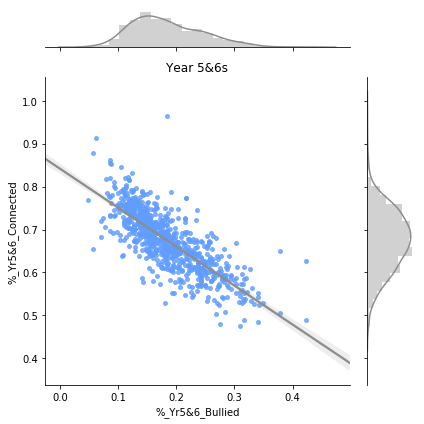

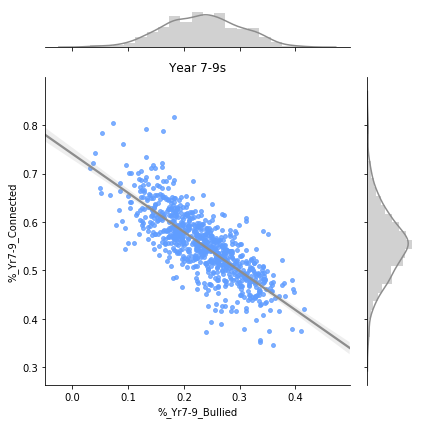

In [51]:
#Read in Bullying and Connectedness Data for each LGA, Merge all years into a single dataset
df_bc = pd.read_excel('VCAMS_Indicator_33_2_Connectedness.xlsx', sheetname='33.2 Year 5 and 6')
df_bc = df_bc.drop(['Numerator', 'Denominator', 'Indicator Type'], axis=1)
columns = ['Year', 'LGA', '%_Yr5&6_Connected']
df_bc.columns = columns

for file_sheet_drop_cols in [('VCAMS_Indicator_33_2_Connectedness.xlsx', '33.2 Year 7 to 9',
                              ['Numerator', 'Denominator', 'Indicator Type'], ['Year', 'LGA', '%_Yr7-9_Connected']),
                             ('VCAMS_Indicator_10_3_Bullying.xlsx', '10.3 Years 5&6',
                              ['Numerator', 'Denominator', 'Unnamed: 5'], ['Year', 'LGA', '%_Yr5&6_Bullied']),
                             ('VCAMS_Indicator_10_3_Bullying.xlsx', '10.3 Years 7-9',
                              ['Numerator', 'Denominator', 'Unnamed: 5'], ['Year', 'LGA', '%_Yr7-9_Bullied'])]:
    df_tmp = pd.read_excel(file_sheet_drop_cols[0], sheetname=file_sheet_drop_cols[1])
    df_tmp = df_tmp.drop(file_sheet_drop_cols[2], axis=1)
    columns = file_sheet_drop_cols[3]
    df_tmp.columns = columns
    df_bc = pd.merge(df_bc, df_tmp, on=['Year', 'LGA'], how='outer')
#________________________________________________________________________________________________________________________________
    
#Replace No Data Point values with nan
df_bc = df_bc.replace('NDP', np.nan)

#Clean LGA strings
df_bc['LGA'] = df_bc['LGA'].replace([' \((.+)\)'], '', regex=True)
df_bc['LGA'] = df_bc['LGA'].replace('Colac-Otway', 'Colac Otway', regex=True)

#Split data to that which summarises Victoria and that which represents each LGA
#Unincoporated Vic refers to some limited parts of Victoria that are not LGAs, will be excluded
summary_LGAs = ['Victoria', 'Victoria - Female', 'Victoria - Male', 'Victoria - Indigenous', 'Victoria - Non-Indigenous', \
                'Victoria - Indigenous Status Unknown', 'Victoria - Aboriginal Status Unknown', 'Victoria - Aboriginal', \
                'Victoria - Non Aboriginal', 'Victoria - Other', 'Victoria - Other Gender', 'Unincorporated Vic']
df_lgas = df_bc.loc[~df_bc['LGA'].isin(summary_LGAs)]

#Drop 2016 because Connectedness data was not measured i.e. It is missing in all LGAs in 2016
df_lgas = df_lgas[df_lgas['Year'] != 2016]

#________________________________________________________________________________________________________________________________

#Impute the mean value of each column into the missing values
print(len(df_lgas[df_lgas.isnull().any(axis=1)]), 'rows with missing values in the bullying & connectedness data')
for feature in list(df_lgas):
    if feature != 'LGA':
        df_lgas['non_missing'] = df_lgas[feature].copy()
        average = df_lgas[feature].mean()
        df_lgas['non_missing'].fillna(average, inplace=True)
        df_lgas[feature] = df_lgas['non_missing']
df_lgas = df_lgas.drop('non_missing', axis=1)
#________________________________________________________________________________________________________________________________
    
#Scatter Bullying and Connectedness for each LGA & Year
sns.jointplot('%_Yr5&6_Bullied', '%_Yr5&6_Connected', data=df_lgas, kind='reg', color='#8D8D8D', annot_kws={"fontsize": 15}, 
              scatter_kws={"s": 15, 'color': '#609DFF'})
plt.title('Year 5&6s')
plt.tight_layout()
plt.show()
print('\n')

sns.jointplot('%_Yr7-9_Bullied', '%_Yr7-9_Connected', data=df_lgas, kind='reg', color='#8D8D8D', annot_kws={"fontsize": 15}, 
              scatter_kws={"s": 15, 'color': '#609DFF'})
plt.title('Year 7-9s')
plt.tight_layout()
plt.show()

The above graphs show that data for year 7-9s is reasonably normally distributed with a strong negative correlation. Year 5 and 6 connectedness data also appears to be normally distributed, whilst the year 5 and 6 bullying data is positively skewed, and may even be bimodal.
It is of no surprise that regions with higher proportions of students experiencing bullying have lower proportions of students feeling connected to their peers.

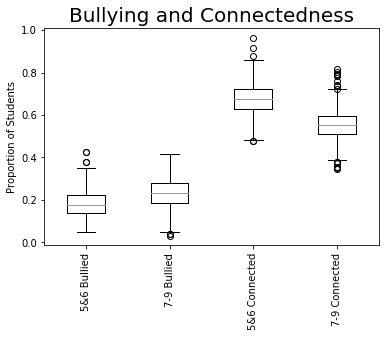

In [4]:
#Boxplots to check for potential outliers
data = [df_lgas['%_Yr5&6_Bullied'], df_lgas['%_Yr7-9_Bullied'], df_lgas['%_Yr5&6_Connected'], df_lgas['%_Yr7-9_Connected'],]

fig, ax = plt.subplots()
ax.set_title('Bullying and Connectedness', size=20)
ax.boxplot(data)
ax.set_ylabel('Proportion of Students')
plt.xticks([1, 2, 3, 4], ['5&6 Bullied', '7-9 Bullied', '5&6 Connected', '7-9 Connected'], rotation='vertical')
#plt.savefig('B&CBox.png', dpi=250)
plt.show()

The above boxplots demonstrate that there are outliers, but also that they are still reasonable values and should not be removed

Data on individual year 12s is read and cleaned. There are many different ways of expressing the same data i.e. "Certificate IV and above" and "Certificate IV or higher", so a dictionary replacement was used.

In [52]:
#Read in yr12 Data - (Data on individual yr12s from 2009 & 2011-2017). Merge all years into a single dataset
#Note: NILFET = Not in the labour force, employment or training
df_yr12 = pd.read_csv('ontrackyear122009.csv')
df_yr12 = df_yr12.drop(['STUDENT ID', 'DEECD_Region', 'METRO/NON-METRO'], axis=1)
columns = ['Education Sector', 'LGA', 'Male?', 'Study Strand', 'Socio-Economic', \
           'Country of Birth', 'LOTE spoken at home', 'Destination', 'Deferred']
df_yr12.columns = columns
#First year read in is 2009
df_yr12['Year'] = 2009

#Every year after is concatenated below the 2009 data
for year in range(2011, 2018):
    df_tmp = pd.read_csv('ontrackyear12'+str(year)+'.csv')
    df_tmp = df_tmp.drop(['STUDENT ID', 'DEECD_Region', 'METRO/NON-METRO'], axis=1)
    column_names = ['Education Sector', 'LGA', 'Male?', 'Study Strand', 'Socio-Economic', \
               'Country of Birth', 'LOTE spoken at home', 'Destination', 'Deferred']
    df_tmp.columns = column_names
    df_tmp['Year'] = year
    df_yr12 = pd.concat([df_yr12, df_tmp])
#________________________________________________________________________________________________________________________________

#Clean yr12 Data (Combine categorical data that describes same value, make missing values np.nan, rename some values)
replacements = {'Study Strand': {'VCE non-VET': 'VCE', 'VCAL only': 'VCAL','VCAL Only': 'VCAL', 'VCE VCAL': 'VCAL'}, \
                'Male?': {'M': True, 'F': False}, \
                'LOTE spoken at home': {'Yes': 1, 'No': 0, \
                                        ' ': np.nan, 'Refused': np.nan, '#NULL!': np.nan, 'Prefer not to say': np.nan}, \
                'Socio-Economic': {'Lowest': 0, 'Upper middle': 2, 'Upper-middle': 2, 'Lower-middle': 1, ' ': np.nan, \
                                   '#NULL!': np.nan, 'Unknown': np.nan, 'Lower middle': 1, 'Highest': 3}, \
                'Country of Birth': {' ': np.nan, 'Other': np.nan, 'Bosnia and Herzegovina': 'Bosnia', \
                                     'China (excl. SARs and Taiwan Province)': 'China', 'Cambodia(Kampuchea)': 'Cambodia', \
                                     'Korea, Republic of (South)': 'South Korea', 'Refused': np.nan, \
                                     'Hong Kong (SAR of China)': 'Hong Kong', "Don't know": np.nan, \
                                     'South Eastern Europe': 'Balkans', '#NULL!': np.nan, 'Unknown': np.nan, \
                                     'Former Yugoslav Republic of Macedonia (FYROM)': 'Macedonia'}, \
                'Destination': {'Certificate IV or higher': 'Certificate', 'Bachelor Degree': 'University', \
                                'Employed part-time': 'Employed', 'Employed full-time': 'Employed', 'NILFET': 'Unemployed', \
                                'Looking for work': 'Unemployed', 'Certificate I-III': 'Certificate', \
                                'Certificates/diplomas': 'Certificate', 'Unknown': 'University', \
                                'Bachelor degree': 'University', 'Traineeship': 'Apprenticeship', \
                                'Apprenticeship/traineeship': 'Apprenticeship', 'Certificate IV and above': 'Certificate'}, \
                'LGA': {'Colac-Otway': 'Colac Otway'}}
df_yr12 = df_yr12.replace(replacements)

Only 3 columns had missing values, so the values in each of these columns are plotted to see if imputation is viable.

In [53]:
#Find number of missing values
print('Number of students in dataset:', df_yr12.shape[0])
print(len(df_yr12[df_yr12.isnull().any(axis=1)]), 'rows with missing values in the student data')

#Plot bar charts for LOTE, Socio-Economics and Country of Birth columns to see if there are appropriate values to impute
#for feature in ['LOTE spoken at home', 'Socio-Economic', 'Country of Birth']:
#    df_yr12[feature].value_counts().plot.bar(title='Number of students: ' + feature, 
#                                             color=[plt.cm.tab20c(np.arange(len(df_yr12)))], figsize=(8, 5), fontsize=22)
#    plt.show()

#Impute appropriate values as determined by bar chart
df_yr12['LOTE spoken at home'].fillna(0, inplace=True)
df_yr12['Country of Birth'].fillna('Australia', inplace=True)
#Only 1000 students with unknown socio-economics, values too varied to complete accuract imputation so rows are dropped
df_yr12.dropna(inplace=True)

#Only 31 nan values for deferred, appropriate to consider these as False as vast majority is False anyway
df_yr12['Deferred'] = df_yr12['Deferred'] == 'Deferred'
#Make new column 'Born in Aus'
df_yr12['Born in Aus'] = df_yr12['Country of Birth'] == 'Australia'

#Convert Nominal Categorical Variables into Binary Vectors
for column in ['Education Sector', 'Study Strand', 'Destination']:
    for value in df_yr12[column].unique():
        df_yr12[value] = np.where(df_yr12[column]==value, 1, 0)
    df_yr12.drop(column, axis=1, inplace=True)
    
#Changed University Falses to Trues if Deferred == True
df_yr12['University'] = df_yr12['University'].where(df_yr12['Deferred']==0, other=1)

Number of students in dataset: 263947
14896 rows with missing values in the student data


Because the vast majority of students did not speak a Language Other Than English (LOTE) at home, missing values in that column were replace with False i.e. the student did not speak a LOTE at home. Because the distribution of socio-economics was fairly evenly spread, it was deemed innappropriate to impute any single value, so instead, rows with a missing socio-economic value were dropped (only 1000 rows of the 260,000+). The missing country of birth  values were imputed to Australia as almost all students were born in Australia.

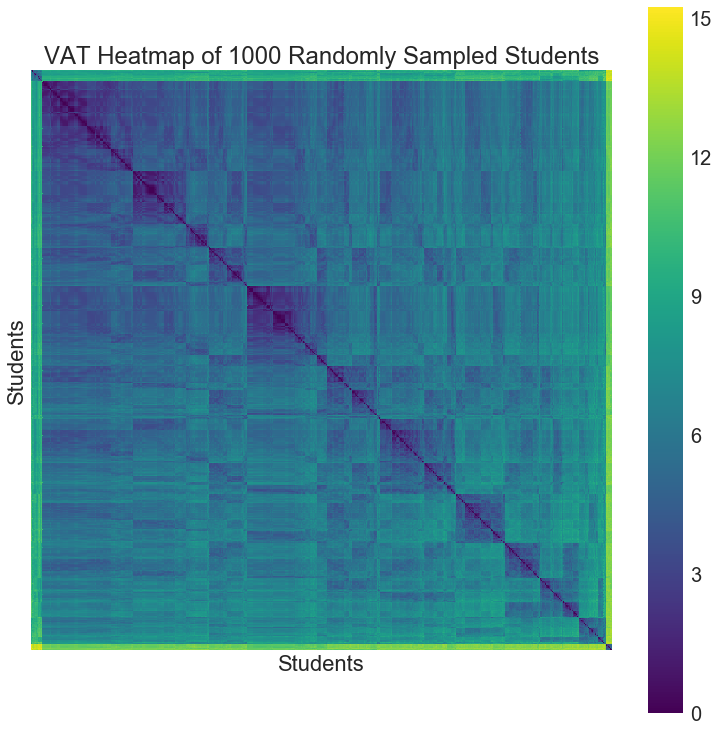

In [51]:
#Perform VAT algorithm to see if students form clusters
#Dissimilarity Matrix
size = 1000
scaler = StandardScaler().fit(df_yr12.drop(['LGA', 'Country of Birth'], axis=1).dropna().sample(size, random_state=0))
X_scaled = scaler.transform(df_yr12.drop(['LGA', 'Country of Birth'], axis=1).dropna().sample(size, random_state=0))

#Apply VAT Algorithm
RV, C, I = VAT(X_scaled)
f, ax = plt.subplots(1, 1, figsize=(13,13))
sns.heatmap(RV, cmap='viridis', xticklabels=False, yticklabels=False, ax=ax, square=True)
ax.set_title("VAT Heatmap of 1000 Randomly Sampled Students")
ax.set_xlabel("Students")
ax.set_ylabel("Students")
plt.show()

The VAT heatmap shows that there are many small clusters of students, this is likely because of the limited number of values that each column has: it is inevitable that some students will have identical features and be indistinguishable in every way that was measured, or at least very close to that.

Data on each LGA is read in and cleaned. Missing values are counted and imputed.

In [54]:
#Read in extensive dataset on LGAs in 2015
df_2015 = pd.read_excel('Data Sheet.xlsx')
print('Columns in original dataset:', len(list(df_2015)))
cols = ['Percentage of inpatient separations from private hospitals', 'Index of Relative Socio-Economic Disadvantage (IRSD)', 
        'People who live near public transport', 'People with private health insurance', 'Female life expectancy', 
        'Male life expectancy', 'People born overseas', 'People who speak a language other than English at home', 
        'People who believe multiculturalism makes life better', 'People who did not complete year 12', 
        'People who rated their community as an active community', 'Percentage of highly disadvantaged SA1s', 
        'Cancer incidence per 1,000 population', 'People who are definitely able to get help from neighbours', 
        'People who help as volunteer', 'Households with mortgage stress', 'Students attending public schools', 
        'Distance to Melbourne', 'Teenage fertility rate', 'Low income families with children', 
        'People who delayed medical consultation, unable to afford', 
        'People who delayed purchasing prescribed medication, unable to afford', 'People with income less than $400 per week',
        'Rental housing that is affordable', 'Children with kindergarten fee subsidy', 
        'Children with emotional or behavioural problems at school entry', 
        'Children with speech or language problems at school entry', 
        'Disability support pension recipients per 1,000 eligible population', 
        'Indirect standardised death rate per 1,000 population', 
        'Child protection investigations completed per 1,000 eligible population', 'LGA Name']
df_2015 = df_2015[cols]
#________________________________________________________________________________________________________________________________

#Clean Numeric Data of "%", "km" and "," Drop from dataset if this does not work
for feature in list(df_2015):
    if feature != 'LGA Name':
        df_2015[feature] = df_2015[feature].replace(['%', ' km', ','], '', regex=True)
        try:
            df_2015[feature] = df_2015[feature].astype('float64')
        except:
            df_2015 = df_2015.drop(feature, axis=1)
        
#Clean LGA text data so that it conforms with other datasets
df_2015['LGA'] = df_2015['LGA Name']
df_2015 = df_2015.drop('LGA Name', axis=1)
df_2015['LGA'] = df_2015['LGA'].replace([' \((.+)\)'], '', regex=True)
df_2015['LGA'] = df_2015['LGA'].replace('Colac-Otway', 'Colac Otway', regex=True)

#Print columns with missing values and the number of missing values
print('***\nNumber of missing values per attribute:')
j=0
for i in range(len(df_2015.isnull().sum().tolist())):
    if df_2015.isnull().sum().tolist()[i] != 0:
        print((str(df_2015.columns[df_2015.isnull().any()].tolist()[j])+':').rjust(72), df_2015.isnull().sum().tolist()[i])
        j += 1

#Impute the mean value of each column into the missing values
for feature in list(df_2015):
    if feature != 'LGA':
        df_2015['non_missing'] = df_2015[feature].copy()
        average = df_2015[feature].mean()
        df_2015['non_missing'].fillna(average, inplace=True)
        df_2015[feature] = df_2015['non_missing']
df_2015 = df_2015.drop('non_missing', axis=1)

print('***\nColumns kept in dataset:    ', len(list(df_2015)))

Columns in original dataset: 404
***
Number of missing values per attribute:
                                                  Distance to Melbourne: 1
                                                 Teenage fertility rate: 16
        Children with emotional or behavioural problems at school entry: 9
                  Indirect standardised death rate per 1,000 population: 1
Child protection investigations completed per 1,000 eligible population: 1
***
Columns kept in dataset:     31


Basic statistics on each Local Government Area is read in and cleaned. Region growth and population density columns are calculated, then the datasets are all merged into two new datasets. df_lgas now contains aggregated student information as well, whilst df_yr12 now contains LGA information for each individual students' respective LGA.

In [55]:
#Read in LGA basic information
df_tmp = pd.read_excel('VIC LGA info.xlsx')
df_tmp = df_tmp.drop(['Council seat', 'Year est.', 'Land Area sq mi'], axis=1)
columns = ['LGA', 'Region', 'Land area km2', 'Pop 2001', 'Pop 2016']
df_tmp.columns = columns

#Clean LGA names and population numbers
df_tmp['LGA'] = df_tmp['LGA'].replace(['Shire of ', ' Shire', 'Rural ', 'City of ', 'Borough of '], '', regex=True)
df_tmp['Pop 2001'] = df_tmp['Pop 2001'].replace(',', '', regex=True)
df_tmp['Pop 2001'] = df_tmp['Pop 2001'].astype('int')
df_tmp['Pop 2016'] = df_tmp['Pop 2016'].replace(',', '', regex=True)
df_tmp['Pop 2016'] = df_tmp['Pop 2016'].astype('int')

df_lgas = pd.merge(df_lgas, df_tmp, on=['LGA'], how='outer')
#________________________________________________________________________________________________________________________________

#Feature engineer Region Growth Statistic and Population Density Statistic
df_lgas['Region Pop Growth'] = df_lgas['Pop 2016']/df_lgas['Pop 2001']
df_lgas['2016 Pop Density'] = df_lgas['Pop 2016']/df_lgas['Land area km2']
df_lgas_copy = df_lgas.copy()
print('Columns in df_lgas before merging:', df_lgas.shape[1])

#df_lgas currently only contains basic information on each LGA, Update each region's information by merging grouped yr12 data
df_lgas_allyears = pd.merge(df_lgas, df_yr12.groupby(['LGA', 'Year'], as_index=False).mean(), on=['Year', 'LGA'], how='outer')
df_lgas_2015 = df_lgas_allyears[df_lgas_allyears['Year']==2015]
#Update each region's information by merging 2015 LGA Data
df_lgas = pd.merge(df_lgas_allyears, df_2015, on=['LGA'], how='outer')

#Add to information for individual year 12s based on their region to prepare for Analysis & DecisionTreeClassifier
df_yr12 = pd.merge(df_yr12, df_lgas_copy, on=['Year', 'LGA'], how='outer')
df_yr12 = pd.merge(df_yr12, df_2015, on=['LGA'], how='outer')
df_yr12.dropna(inplace=True)

### IMPORTANT ###
#df_lgas holds merged data on each LGA, whilst df_yr12 holds merged data on each student

#Remove rows where all of the bullying and connectedness data is missing
df_lgas = df_lgas[pd.notnull(df_lgas['%_Yr7-9_Bullied'])|pd.notnull(df_lgas['%_Yr5&6_Bullied'])
          |pd.notnull(df_lgas['%_Yr7-9_Connected'])|pd.notnull(df_lgas['%_Yr5&6_Connected'])]

#Impute mean of each column into missing values for each column,University is not imputed as it is being predicted
for feature in list(df_lgas):
    if feature not in ['LGA', 'Region', 'University']:
        df_lgas[feature].fillna((df_lgas[feature].mean()), inplace=True)

#There were no recorded students from Golden Plains or Queenscliffe
df_lgas_2015 = df_lgas_2015[~df_lgas_2015['LGA'].isin(['Golden Plains', 'Queenscliffe'])]
for feature in list(df_lgas_2015):
    if feature not in ['LGA', 'Region']:
        df_lgas_2015.fillna((df_lgas_2015[feature].mean()), inplace=True)

print('Columns in df_lgas after merging:', df_lgas.shape[1])

Columns in df_lgas before merging: 12
Columns in df_lgas after merging: 60


To begin the basic EDA, a correlation matrix is constructed and features with very low correlations (close to 0) are removed. The features are then reordered so that features that are positively correlated are next to each other.

C:\Users\Cameron\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


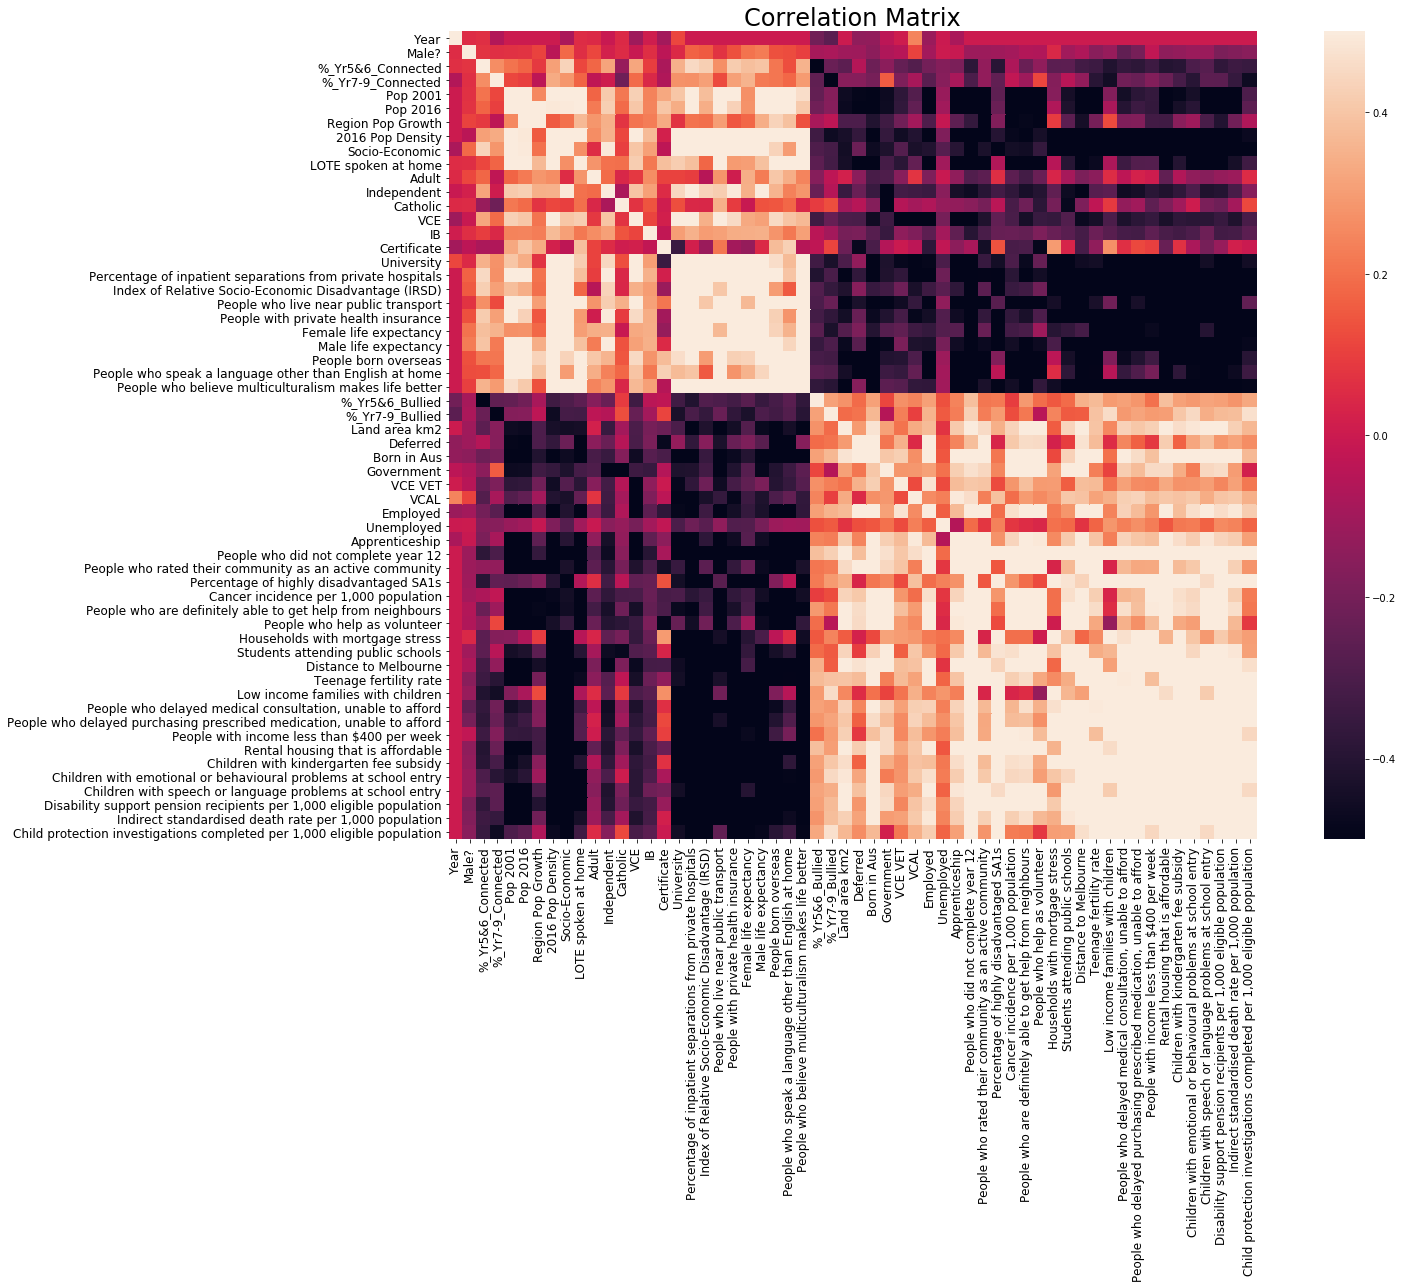

In [56]:
#Exploratory Data Analysis
#Remove NA values and scale data for later techniques
df_model = df_lgas.drop(['LGA', 'Region'], axis=1).dropna()

#Rearrange columns
new_order = [0, 10, 1, 2, 6, 7, 8, 9, 11, 12, 15, 17, 18, 20, 22, 23, 24] + [i for i in range(28,37)]
[new_order.append(i) for i in range(1, len(list(df_model))) if i not in new_order]
new_list = [list(df_model)[i] for i in new_order]
df_model = df_model[new_list]

#Scaled data to compute correlations
scaler = StandardScaler().fit(df_model)
scaled = scaler.transform(df_model)
df_scaled = pd.DataFrame(data=scaled, index=np.arange(0, len(scaled)), columns=list(df_model))

#Calculate correlation
corr = df_scaled.corr()

#Construct correlation heatmap
fig, ax = plt.subplots(figsize=(24, 18))
arr_corr = corr.as_matrix()
hm = sns.heatmap(arr_corr, cbar=True, vmin=-0.5, vmax=0.5, annot_kws={'size': 4}, square=True)

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=12)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=12)
ax.set_title('Correlation Matrix', fontsize=24)
plt.tight_layout()

It appears that the features on the top half of the matrix are all positively related to a region being populous and of high socio-economics. Conversely, the lower features appear to be positively related to a region being very isolated and of low socio-economics. It is important to remember the distinction between correlation and causation here. Using common sense, it is inferred for instance that affordable rental housing is not alone diminishing the university participation rates if at all! Instead, it is likely these correlations are more like indicators of underlying confounding factors that are also causing low university participation. Using domain knowledge alone, it is hypothesised that socio-economics would have a potentially causal relationship with most of these features including university participation.

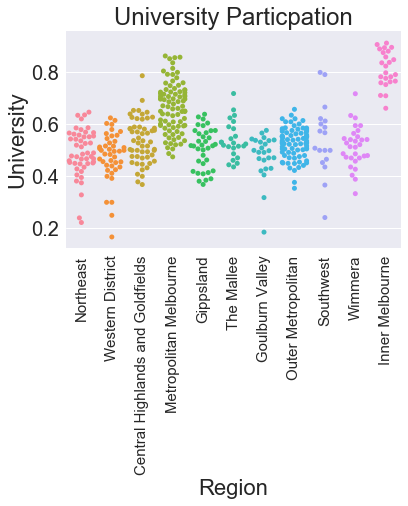

In [55]:
#Plot swarmplot of university participation for each region
ax = sns.swarmplot(x="Region", y="University", data=df_lgas)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=15)
ax.set_title("University Particpation")
plt.show()

This swarmplot clearly shows that Inner Melbourne regions and Metropolitan Melbourne regions have distinctly different proportions of students going to university, whilst most other areas are likely to have indistinguishable rates. This is supported by the correlations previously found as highly populous and wealthy regions (an adequate description for most Melbourne LGAs) have greater university participation rates.

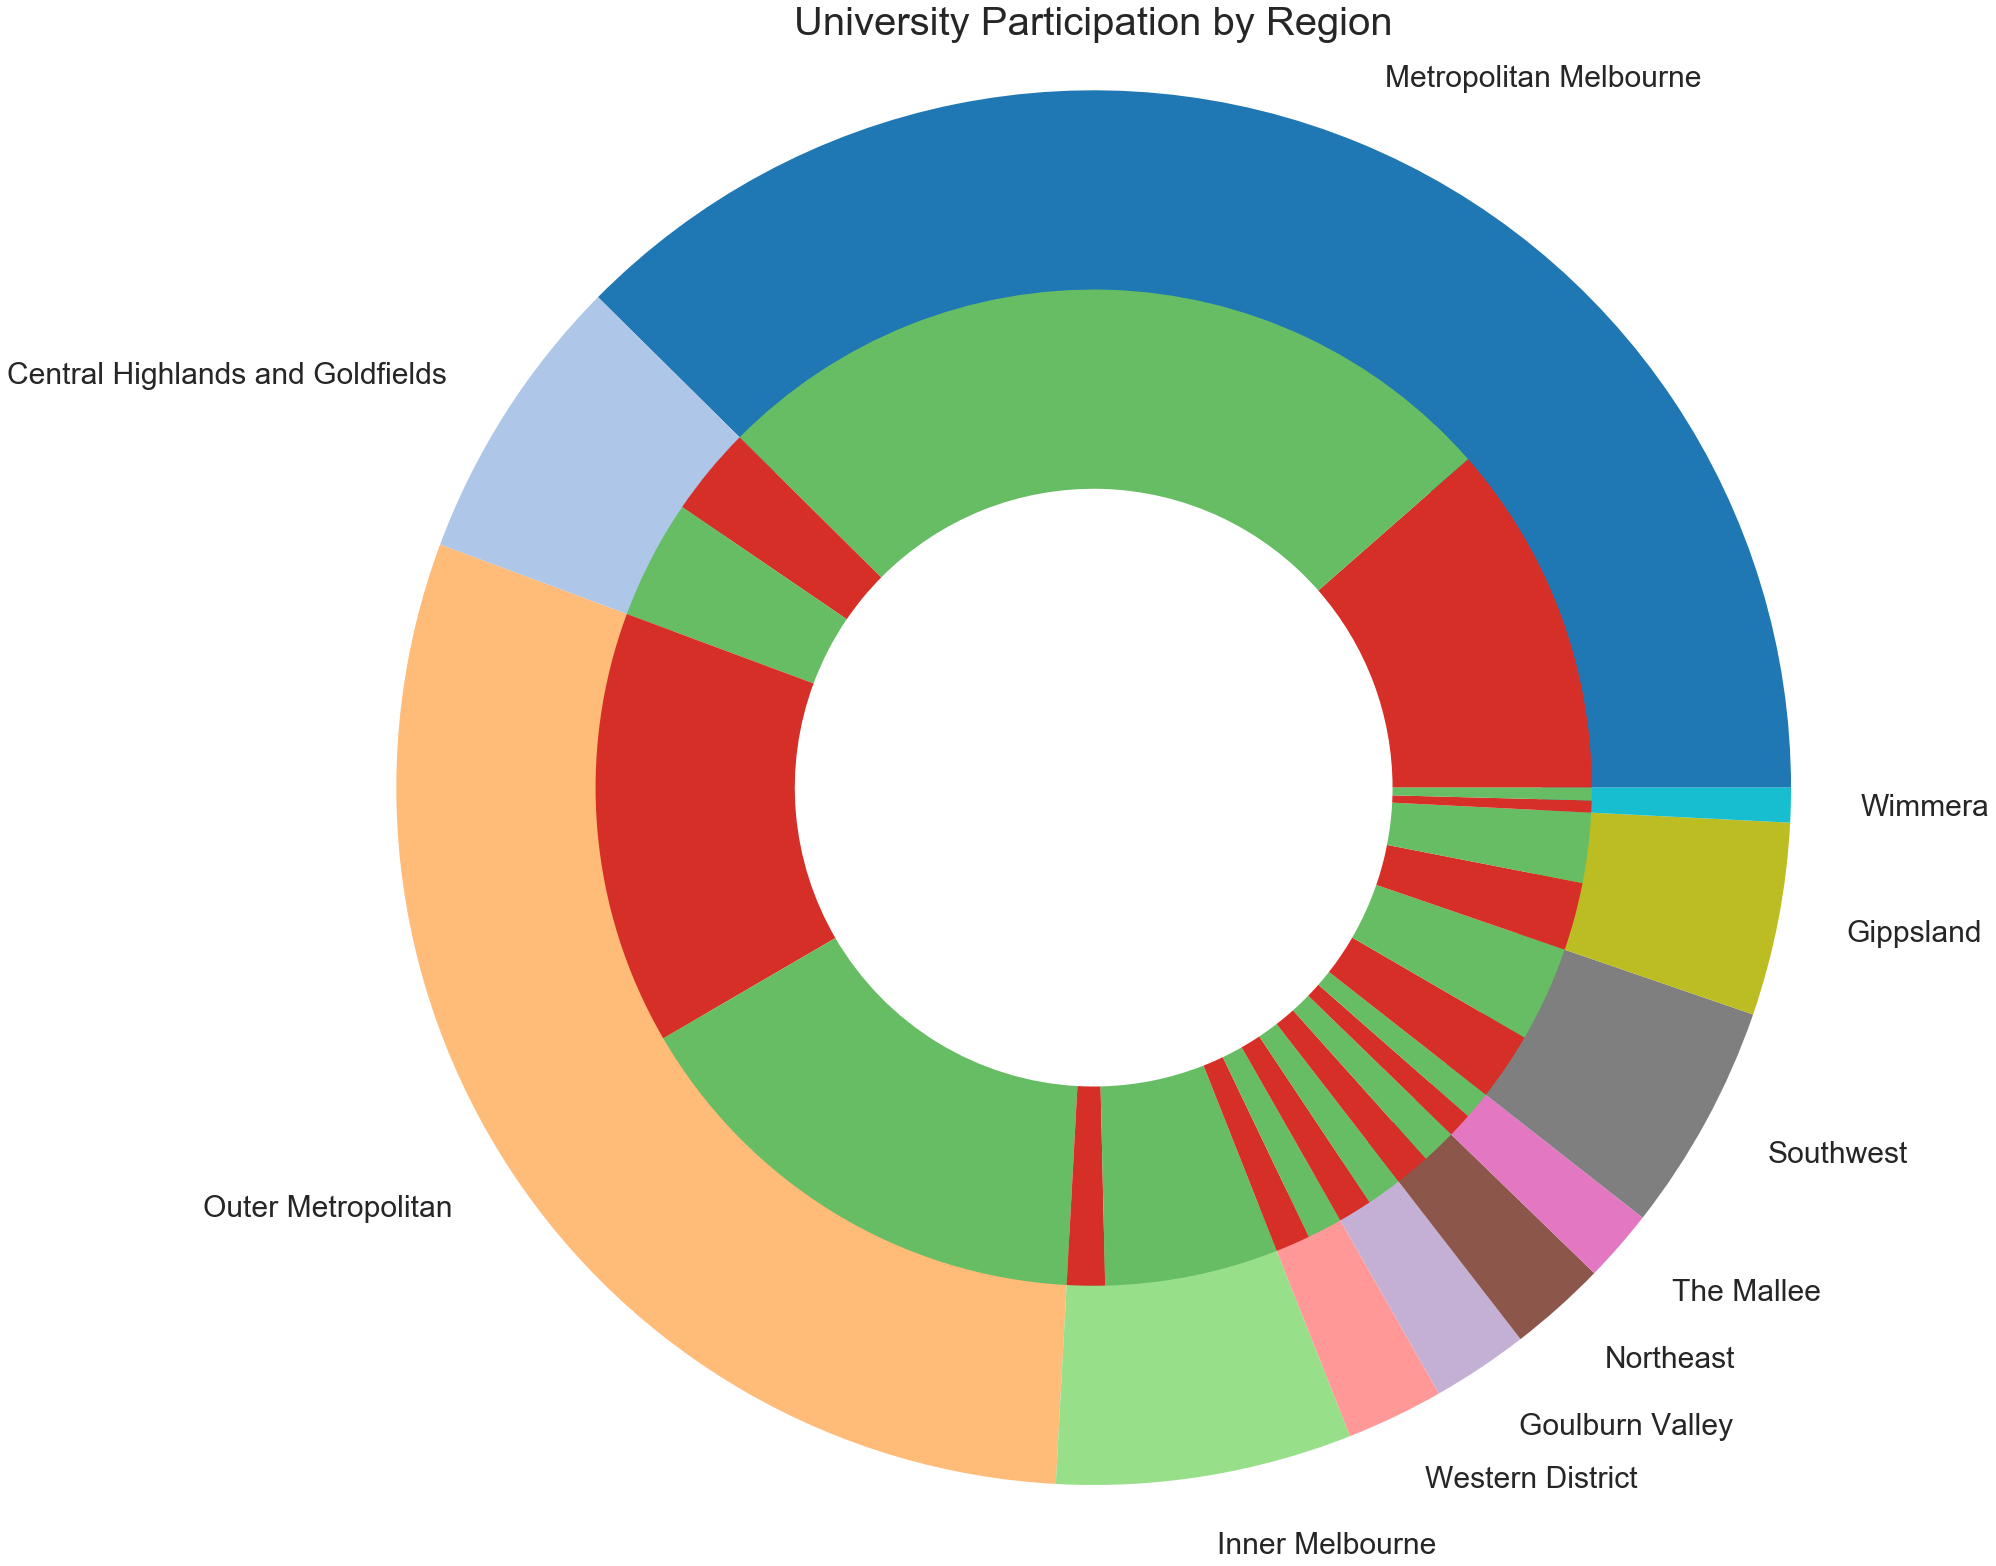

In [56]:
#Plot a nested pie chart to show proportions of students going to university in each region
counts = []
for region in df_yr12['Region'].unique():
    counts.append([len(df_yr12[(df_yr12['Region']==region)&(df_yr12['University']==0)]), 
                   len(df_yr12[(df_yr12['Region']==region)&(df_yr12['University']==1)])])

#Make data
group_names = [region for region in df_yr12['Region'].unique()]
group_size = [a+b for a,b in counts]
subgroup_size = [item for sublist in counts for item in sublist]
 
#First Ring (outside) Each segment represents the proportion of the students that live in that region
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.4, labels=group_names, colors=cm.tab20(np.arange(11)/11.))
for i in range(11):
    _[i].set_fontsize(30)
plt.setp(mypie, width=0.5)
 
#Second Ring (Inside) Green = Proportion of students going to uni, Red = Proportion of students not going to uni
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, colors=cm.RdYlGn([0.1, 0.8]*11))
plt.setp(mypie2, width=0.4)
plt.margins(0,0)
plt.title('University Participation by Region', y=1.1, fontsize=40)
plt.tight_layout()
#plt.savefig('UniParPie.png', dpi=250, bbox_inches = "tight")
plt.show()

This nested pie chart shows both the proportion of year 12 students in each region (the outer ring) and the proportion of students going on to university (represented by green in the inner ring). As seen in the swarmplot, notice that Inner Melbourne and Metro Melbourne have disproportionately large green segments, whilst every other region has approximiately half of students saying that they will go to university.

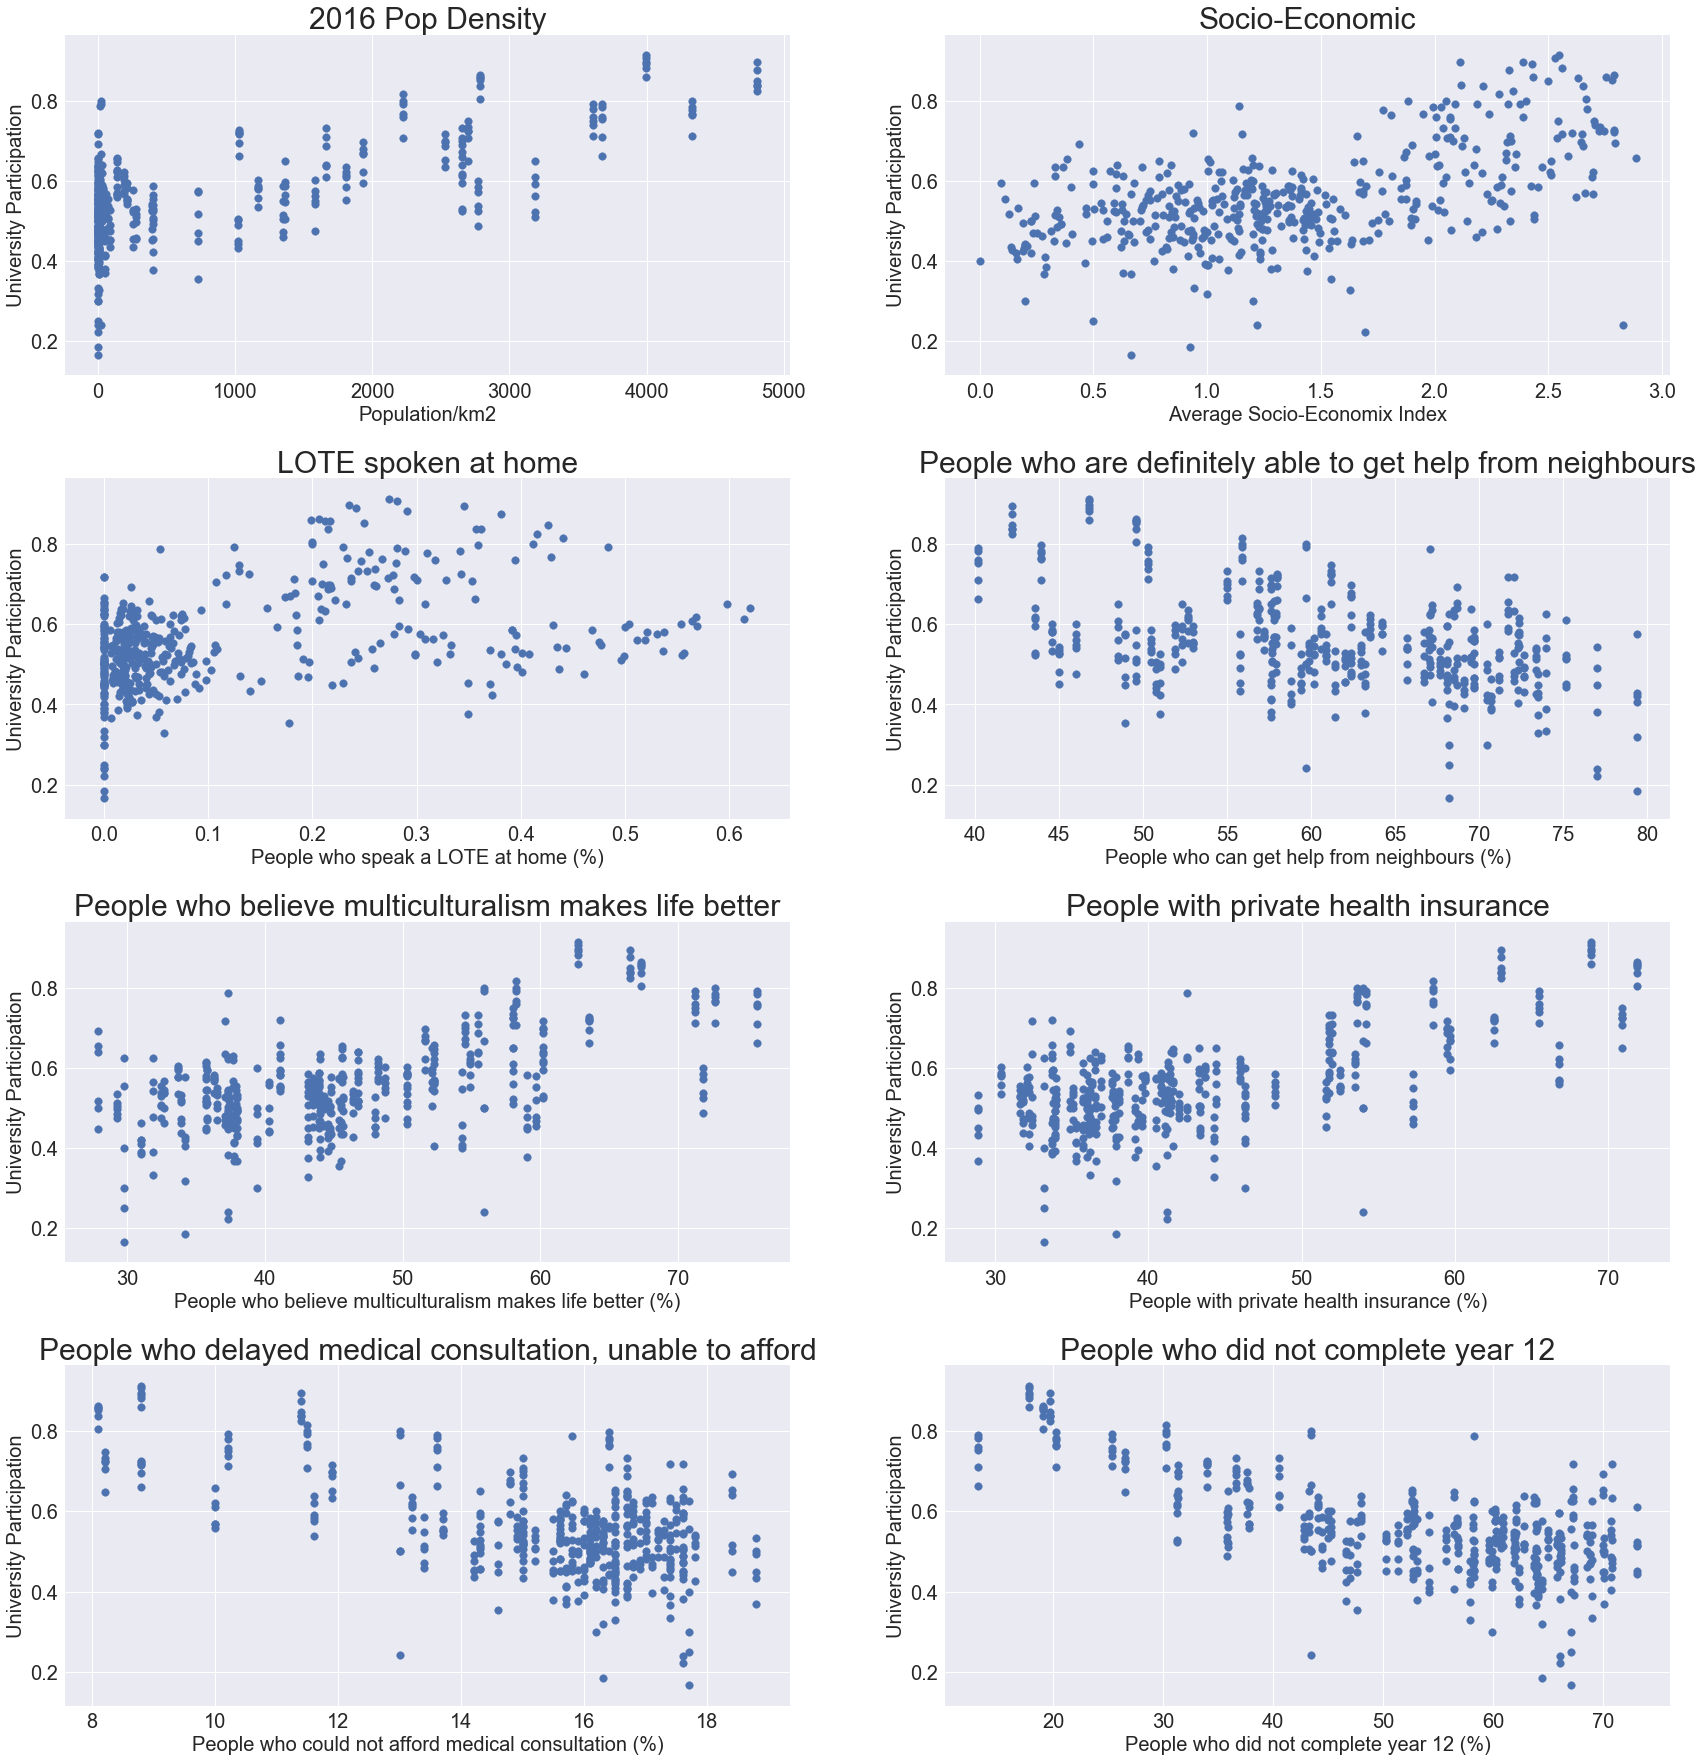

In [57]:
#After looking at the correlation heatmap, plot some of the relationships with significant pearson coefficients
#List of x axes features and labels. Nested in this structure for easy access when plotting
features = [[['2016 Pop Density', 'Population/km2'], ['Socio-Economic', 'Average Socio-Economix Index']], 
            [['LOTE spoken at home', 'People who speak a LOTE at home (%)'], 
             ['People who are definitely able to get help from neighbours', 'People who can get help from neighbours (%)']], 
            [['People who believe multiculturalism makes life better', 
              'People who believe multiculturalism makes life better (%)'],
             ['People with private health insurance', 'People with private health insurance (%)']],
            [['People who delayed medical consultation, unable to afford', 
              'People who could not afford medical consultation (%)'], 
             ['People who did not complete year 12', 'People who did not complete year 12 (%)']]]
#Plot!
f, ax = plt.subplots(4, 2, figsize=(25, 25))

for x in range(2):
    for y in range(4):
        ax[y, x].scatter(df_lgas[features[y][x][0]], df_lgas['University'], s=60)
        ax[y, x].set_title(features[y][x][0], size=30)
        ax[y, x].set_xlabel(features[y][x][1], size=20)
        ax[y, x].set_ylabel('University Participation', size=20)

f.tight_layout()
plt.show()

Some of the more interesting correlations were picked from the matrix to investigate as scatter plots. Note that the vertical 'streaks' of points displayed are from the same LGA measured over many years, and possibly should have been aggregated into one value before graphing or even measuring the correlation. It is thought that it would make only minor differences to the correlation coefficient.
Particularly noticeable in the Socio-Economic plot are two groups. It appears that the left most group forms no relationship between socio-economics and university participation, whilst the right group of higher socio-economics has a positive relationship. This requires more investigation, as although one explanation is that university participation flat lines at some threshold socio-economic, another intriguing explanation involves some real difference apart from socio-economics between the two groups of students. The latter notion is especially supported by the fact that the structural change is so abrupt.
In retrospect, it is also interesting to note the outlier at (2.7, 0.25). It appears that there is a region with high socio-economic status, yet with only a quarter of students going on to university. This also requires further investigation.

Variance explained by each PC [0.33076584 0.11019865]


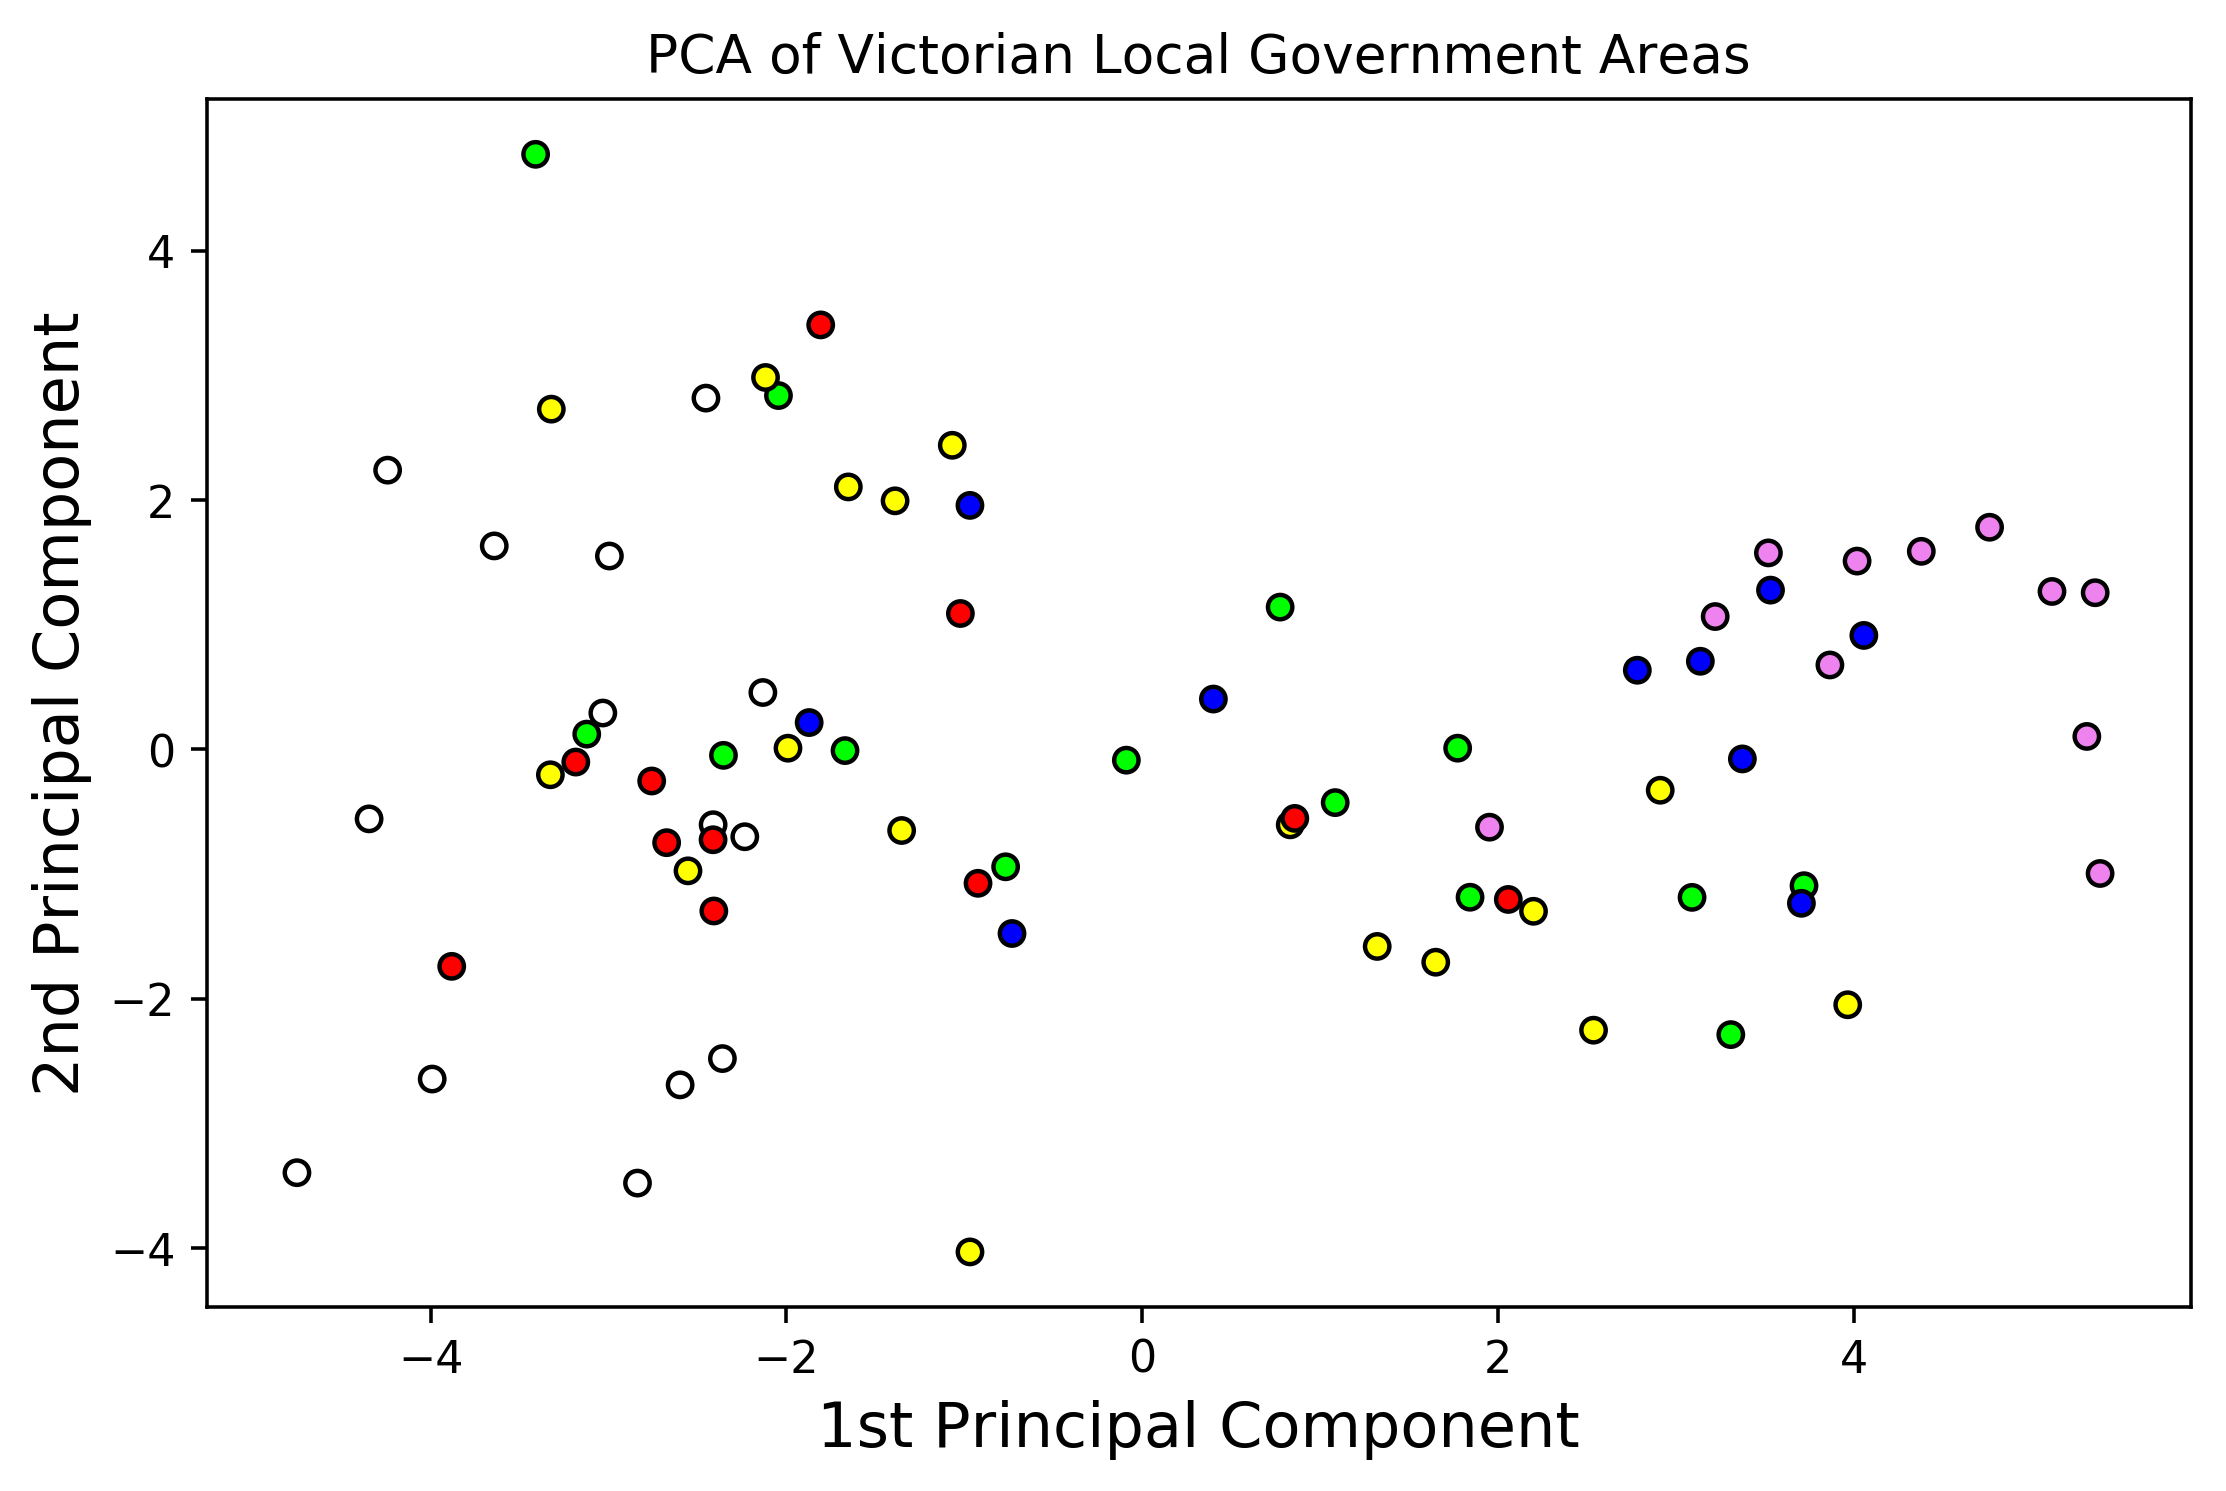

In [15]:
#PCA for df_lgas_2015
#First scale data
scaler = StandardScaler().fit(df_lgas_2015.drop(['University', 'LGA', 'Region'], axis=1).dropna())
X_scaled = scaler.transform(df_lgas_2015.drop(['University', 'LGA', 'Region'], axis=1).dropna())

pca = PCA(n_components=2)
pca_model = pca.fit_transform(X_scaled)
#The amount of variance explained by each PC
print("Variance explained by each PC", pca.explained_variance_ratio_)   

#Set up the colour scheme
colours = []
i=0
while (len(colours) < 6) or (i in range(len(df_lgas_2015))):
    if df_lgas_2015['University'].iloc[i] < 0.45:
        colours.append('white')
    elif df_lgas_2015['University'].iloc[i] < 0.50:
        colours.append('red')
    elif df_lgas_2015['University'].iloc[i] < 0.55:
        colours.append('yellow')
    elif df_lgas_2015['University'].iloc[i] < 0.60:
        colours.append('lime')
    elif df_lgas_2015['University'].iloc[i] < 0.70:
        colours.append('blue')
    else:
        colours.append('violet')
    i += 1
        
#Plot data along the first two principal components
plt.figure(figsize=(8, 5), dpi=320)
plt.scatter(pca_model[:,0], pca_model[:,1], s=30, c=colours, edgecolor='black')
plt.title('PCA of Victorian Local Government Areas')
plt.xlabel('1st Principal Component', fontsize=14)
plt.ylabel('2nd Principal Component', fontsize=14)
plt.show()

Principal Component Analysis (PCA) was performed on the LGA dataset (coloured by university participation band) to see if there was any clustering of regions with similar university participation rates. Because clustering to some extent was observed (see the pink cluster to the right, the white cluster to the left etc.), it was deemed appropriate to attempt K-Nearest Neighbours (KNN) clustering to predict the university participation band that a region would fall into given its other features.

In [89]:
############### Applied Neural Network (2019 work)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

num_classes = 2

df_x = df_yr12[['LGA', 'Male?', 'Socio-Economic', 'Country of Birth', 'LOTE spoken at home', 'Year', 'Born in Aus',
               'Adult', 'Government', 'Independent', 'Catholic', 'VCE VET', 'VCE', 'VCAL', 'IB', 'Region', 'University']]
df_x[['Male?', 'Born in Aus']] *= 1.0
df_x['Year'] -= 2009
#One Hot encode categorical Columns
a = 1
if a:
    one_hot = pd.get_dummies(df_x['LGA'])
    df_x = df_x.drop('LGA', axis = 1)
    df_x = df_x.join(one_hot)

    one_hot = pd.get_dummies(df_x['Country of Birth'])
    df_x = df_x.drop('Country of Birth', axis = 1)
    df_x = df_x.join(one_hot)
    
    one_hot = pd.get_dummies(df_x['Region'])
    df_x = df_x.drop('Region', axis = 1)
    df_x = df_x.join(one_hot)
    
#Normalise numerical columns
for column in ['Socio-Economic', 'Year']:
    df_x[column] /= df_x[column].max()

df_y = df_x['University']
y = pd.get_dummies(df_y)

df_x.drop('University', axis=1, inplace=True)
df_x.sample(5)
           
x = df_x.to_numpy()
y = y.to_numpy()
y

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [92]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=len(list(df_x))))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x, y,
          batch_size=100,
          epochs=3,
          validation_split = 0.2)

Train on 164209 samples, validate on 41053 samples
Epoch 1/3
164209/164209 [==============================] - 8s 46us/step - loss: 0.5334 - acc: 0.7262 - val_loss: 0.5911 - val_acc: 0.6752
Epoch 2/3
164209/164209 [==============================] - 7s 42us/step - loss: 0.5260 - acc: 0.7303 - val_loss: 0.5951 - val_acc: 0.6754
Epoch 3/3
164209/164209 [==============================] - 7s 43us/step - loss: 0.5242 - acc: 0.7312 - val_loss: 0.5934 - val_acc: 0.6745


University participation divided into 3 bands: ([0,0.5), [0.5,0.7), [0.7,1.0])
Train accuracy: 77.05%
Test accuracy: 75.00%


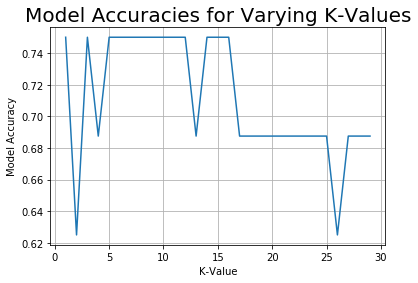

In [16]:
#PCA showed that KNN classification could work to predict what university participation a specific region will be in
df_model = df_lgas_2015.drop(['Certificate', 'Employed', 'Unemployed', 'Apprenticeship', 'Adult', 'Government', 'Independent', 
                              'Catholic', 'VCE VET', 'VCE', 'VCAL', 'IB', 'Land area km2', 'Pop 2001', 'Pop 2016', 
                              'Region Pop Growth', '2016 Pop Density', 'Male?', 'Socio-Economic', 'LOTE spoken at home', 
                              'Deferred', 'Born in Aus',],axis=1).copy()

#Discretise University column into bands of [0,0.5), [0.5,0.7] & (0.7,1.0] represented by ordinal integers
df_model['University'].loc[df_model['University'] < 0.5] = 0
df_model['University'].loc[(df_model['University'] >= 0.5)&(df_model['University'] < 0.70)] = 1
df_model['University'].loc[(df_model['University'] >= 0.7)&(df_model['University'] <= 1.0)] = 2
df_model['University'] = df_model['University'].astype('int')

print('University participation divided into 3 bands: ([0,0.5), [0.5,0.7), [0.7,1.0])')

#Split training and testing data
y = df_model['University']
X = df_model.drop(['University', 'Region', 'LGA'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

#Train KNN
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
#Predict percentage of students leaving to university given LGA information using K-NN
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print('Train accuracy: {0:.2f}%'.format(100*accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {0:.2f}%'.format(100*accuracy_score(y_test, y_test_pred)))

#Try a large range of k-values to search for an optimal k-value
ks = range(1, 30)
accu_list = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accu_list.append(accuracy_score(y_test, y_pred))

#Plot the accuracy for each K-Value
plt.plot(ks, accu_list)
plt.title('Model Accuracies for Varying K-Values', fontsize=20)
plt.xlabel('K-Value')
plt.ylabel('Model Accuracy')
plt.grid()
plt.show()

Every k-value from 0-30 exclusive was trialled to find an optimal k-value. A value of 8 was settled on, providing 75% test accuracy, which is less impressive when reminded that the model only had to predict whether a region's university participation rates were less than 50%, between 50%-70% or greater than or equal to 70%.

54 features used
Train accuracy: 75.13%
Test accuracy: 74.20% 



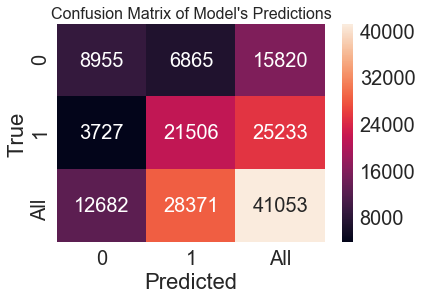

Accuracy from always predicting University = 25223/41053 = 61.44%



In [58]:
#A decision tree classifer can be used to predict whether or not an individual student will go to university
#Remove non-numeric features and features that are only known once a student has said where they are going
#Will reduce accuracy but make a fair model
model_values = [x for x in list(df_yr12) if (x not in ['Country of Birth', 'LGA', 'Region', 'Employed', 'Unemployed', \
                                                       'Apprenticeship', 'Certificate'])]
print(len(model_values), 'features used')
df_model = df_yr12[model_values].dropna()
df_model.University = df_model.University.astype('int')

#Split training and testing data
y = df_model['University']
X = df_model.drop('University', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

#Perform DT training and prediction
dt = DecisionTreeClassifier(random_state=0, max_depth=11, min_samples_split=16)
dt.fit(X_train, y_train)
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
print('Train accuracy: {0:.2f}%'.format(100*accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {0:.2f}%'.format(100*accuracy_score(y_test, y_test_pred)), '\n')
    
#Plot confusion matrix to check for bias, sensitivity and specificity
ax = plt.axes()
sns.set(font_scale=2)
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={"size": 20})
ax.set_title("Confusion Matrix of Model's Predictions", fontsize=16)
plt.show()

#Use values from the confusion matrix to calculate a baseline from which to measure the Dtree model
print('Accuracy from always predicting University = 25223/41053 = {0:.2f}%\n'.format(100*25223/41053))
#________________________________________________________________________________________________________________________________

#How hyperparameters were chosen: (COMMENTED OUT TO PREVENT ACCIDENTAL RUNNING (it takes a long time to run))
#hyperparameters = []
#for min_split in range(2,21,2):
#    for depth in range(1,20,2):
#        dt = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_split=min_split)
#        dt.fit(X_train, y_train)
#        y_train_pred = dt.predict(X_train)
#        y_test_pred = dt.predict(X_test)
#        hyperparameters.append((accuracy_score(y_test, y_test_pred), min_split, depth))
#Hyperparameters that gave highest test accuracy score were chosen
#print('Optimal (accuracy, minimum splits in tree, maximum depth of tree) =', sorted(hyperparameters)[-1])

Using all 54 features available, a tuned decision tree classifier was implemented to predict whether or not an individual student would go to university. This resulted in 74.2% test accuracy but a horrifically uninterpretable model. Also, the bias speaks for itself in the confusion matrix above where almost half of students who did not go to university were predicted to anyway. A stratified training sample was trialled (50/50 students that did and did not go to university) but did not improve accuracy.
Also note that if the model predicted that all students go to university, it would have an accuracy of 61.4% (since approx. 61.4% of students go to university).

Train accuracy: 70.05%
Test accuracy: 70.41% 

Is a student the specified characteristics likely to go to university?
Yes, of students with the specified features in the dataset:
27265 students went to uni
5263 students did not go to uni



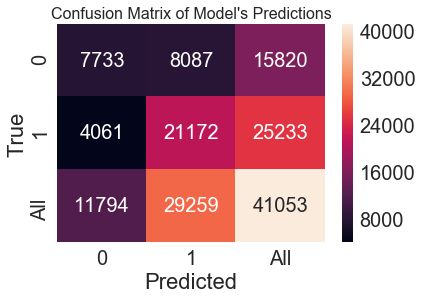

In [59]:
#Highly interpretable models are desirable, it was discovered by slowly removing variables that only these three features
#were required to get a test accuracy of approximately 70%: minimally worse that the last model
model_values = ['Independent', 'VCE', 'VCAL', 'University']
df_model = df_yr12[model_values].dropna()
df_model.University = df_model.University.astype('int')

#Split training and testing data
y = df_model['University']
X = df_model.drop('University', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

#Perform DT training and prediction
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
print('Train accuracy: {0:.2f}%'.format(100*accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {0:.2f}%'.format(100*accuracy_score(y_test, y_test_pred)), '\n')

#A student can be imagined with these three variables, and the model will predict whether or not they are likely to go
#to university based on the actions of other students that match in these ways
ind=1; vce=1; vcal=0
#The dataset is scoured for students with the above features, and the number of these students is printed out below
stud_with_feats = df_model.loc[(df_model['VCAL'] == vcal)&(df_model['VCE'] == vce)
                   &(df_model['Independent'] == ind)].University.value_counts()

#Make prediction for imagined student
print('Is a student the specified characteristics likely to go to university?')
if dt.predict([[ind, vce, vcal]])==[1]:
    print('Yes, of students with the specified features in the dataset:')
else:
    print('No, of students with the specified features in the dataset:')
print(stud_with_feats[1], "students went to uni")
print(stud_with_feats[0], "students did not go to uni\n")
    
#Plot confusion matrix to check for bias, sensitivity and specificity
ax = plt.axes()
sns.set(font_scale=2)
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={"size": 20})
ax.set_title("Confusion Matrix of Model's Predictions", fontsize=16)
plt.show()
#________________________________________________________________________________________________________________________________

#Export decision tree for visualisation
with open("d_tree.txt", "w") as f:
    f = export_graphviz(dt, out_file=f)

It was discovered that almost all of the features could be removed without reducing accuracy 'too' much. In fact, only three features were retained ("VCE", "VCAL" and "Independent") to result in a test accuracy of 70.4%. The final decision tree is elegant and simple. Shown below, the numbers of students not going to uni is on the left of each node, and those going to uni is on the right. The main issue with this model is the further increase in bias towards predicting that students will go to university. The confusion matrix shows that the model's predictions for students who actually did not go to university has surpassed 50% in the wrong way.

<img src="Final DT.png">

### Conclusion
The analysis and correlation heatmap demonstrated that many factors are strongly associated with university participation, indicating that predictive machine learning models can be implemented effectively. Some correlations are hypothesised to be rather causations such as socio-economics and LOTE spoken at home. It is known that many families from non-English speaking backgrounds move to Australia, (into cities in particular) specifically for the university opportunities. 
The code containing the machine learning training, testing and predicting clearly answer the research question; We can indeed make predictions for the university participation of both regions and individuals with upwards of 75% accuracy. The next challenge is to dig into the data and find which factors are the real causes for the discrepencies in university participation, and ensure that all students have equal access to tertiary education. This could be tackled with advanced statistical techniques that can account for confounding variables.
It is also quite possible if not likely that disproportionate amounts of students in rural areas simply have no interest in attending university, and it is difficult to determine when this is the case rather than inequality by just looking at the data.
When cutting down features for the interpretable decision tree model, it was disappointing to see that whether or not a student went to a private school was retained as one of the three most important factors in determining a student's prospects at going to university. This feature trailed too closely behind a Victorian Certificate in Applied Learning (VCAL) education which essentially disqualifies a student from going to university straight out of school. It can be inferred from the importance of this feature that there is certainly inequality between which type of school a student attends, and this alone is enough to warrant further investigation into inequality in tertiary education opportunities.